## Classifying Hand written digits

In [ ]:
# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 9
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [ ]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

# Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

# Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((train_mean, ), (train_std, ))
])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Train Data: Mean=0.1306604762738429, Std=0.30810780717887876


## Part 0: Inspect dataset (0 points)

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=-0.009814570657908916, Std=0.9916517734527588


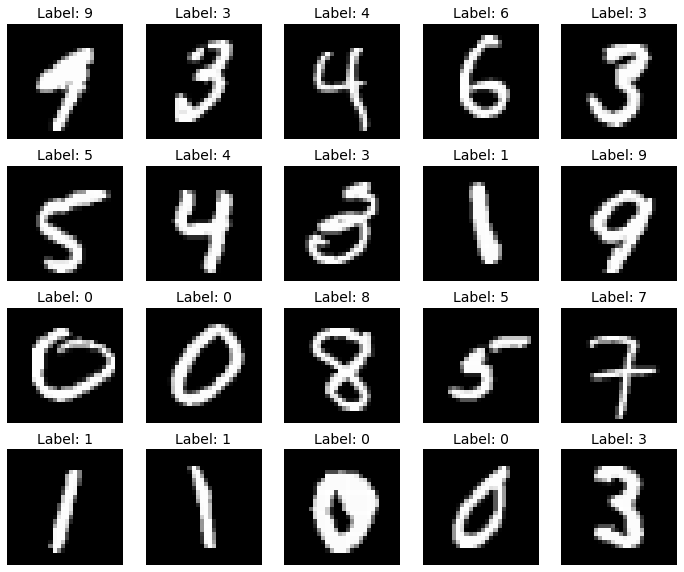

In [ ]:
# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
# > plt.subplot(4, 5, i+1)
# > plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
# > plt.title(f'Label: {labels[i]}', fontsize=14)
# > plt.axis('off')

images, labels = iter(train_loader).next()

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))
# ------------------
for i in range(20):

  plt.subplot(4, 5, i+1)
  plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
  plt.title(f'Label: {labels[i]}', fontsize=14)
  plt.axis('off')
# ------------------

### Implement a two-layer neural network

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class MNISTClassifierMLP(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        self.input_size = input_size


        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,10)
        # self.softmax = nn.Softmax(dim=1)
        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        x = self.flatten(x)

        # ------------------
        # x = torch.nn.functional.relu(self.fc1(x))
        # x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.relu(x)
        # y_output = self.softmax(x)
                
        return x
        # ------------------

model = MNISTClassifierMLP().to(DEVICE)

# sanity check
print(model)

from torchsummary import summary
summary(model, (1,28,28))

MNISTClassifierMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
X = torch.randn(28,28)

In [ ]:
X.shape

torch.Size([28, 28])

In [ ]:
model(X.view(-1,784))

tensor([[-0.3184,  0.1422, -0.0929, -0.3114, -0.3157,  0.1949, -0.0193, -0.3601,
          0.3487, -0.0633]], grad_fn=<AddmmBackward0>)

###Implement an optimizer to train the neural net model

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    train_num_correct = 0
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.reshape(-1,28*28).to(device), label.to(device)

        # ------------------
        output = model(img)

        _,pred_lab = torch.max(output.data,1)
        train_num_correct += (pred_lab == label.data).sum()

        loss = criterion(output,label)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # ------------------
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:    
          losses.append(loss.item())
          counter.append(
              (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter, train_num_correct

### Run the optimization procedure and test the trained model

In [ ]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    test_num_correct = 0
    
    with torch.no_grad():
        for i,(img, label) in enumerate(test_loader):
            
          img, label = img.reshape(-1,28*28).to(device), label.to(device)

          # ------------------
          pred = None # Get index of largest log-probability and use that as prediction

          output = model(img)
          _,pred_lab = torch.max(output.data,1)
          test_num_correct += (pred_lab == label.data).sum()
          test_loss += criterion(output, label)

    test_loss /= len(test_loader.dataset)
    return test_loss, test_num_correct

Train the model using the cell below. Hyperparameters are given.

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
test_losses = []
test_correct = []
train_correct = []
train_counter = []
test_counter = []

# using cross entropy loss to predict  
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter, x= train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss,test_num_correct = test_one_epoch(test_loader, model, DEVICE)
    tr_loss,train_num_correct = test_one_epoch(train_loader,model,DEVICE) # Discussed with Apoorva Jarmale

    # Record results
    train_losses.extend(train_loss)
    train_correct.append(train_num_correct)
    train_counter.extend(counter)

    test_losses.append(test_loss)
    test_correct.append(test_num_correct)


Epochs: 100%|██████████| 10/10 [04:40<00:00, 28.06s/it]


In [ ]:
print(f"Train accuracy: {train_correct[-1]/len(train_loader.dataset)}")
print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Train accuracy: 0.9678166508674622
Test accuracy: 0.9629999995231628


In [ ]:
import numpy
print("Training Cross Entropy loss:",numpy.average(train_losses))
print("Testing Cross Entropy loss:",numpy.average(test_losses))

Training Cross Entropy loss: 0.22784689706232814
Testing Cross Entropy loss: 0.0030048494


In [ ]:
len(train_counter)

90

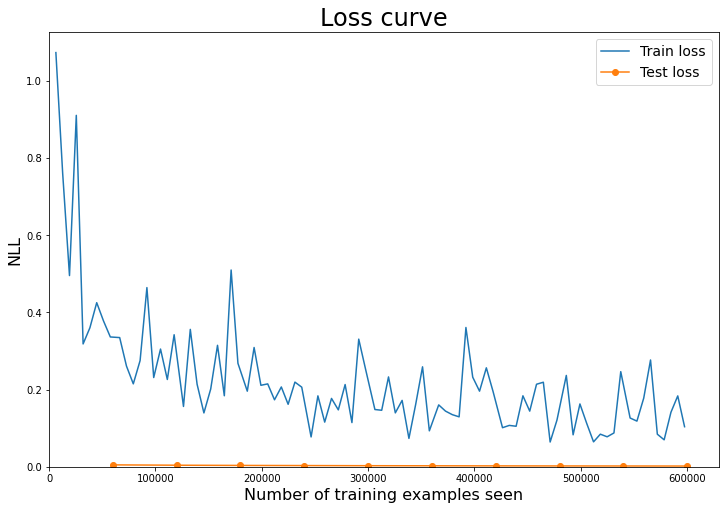

In [ ]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

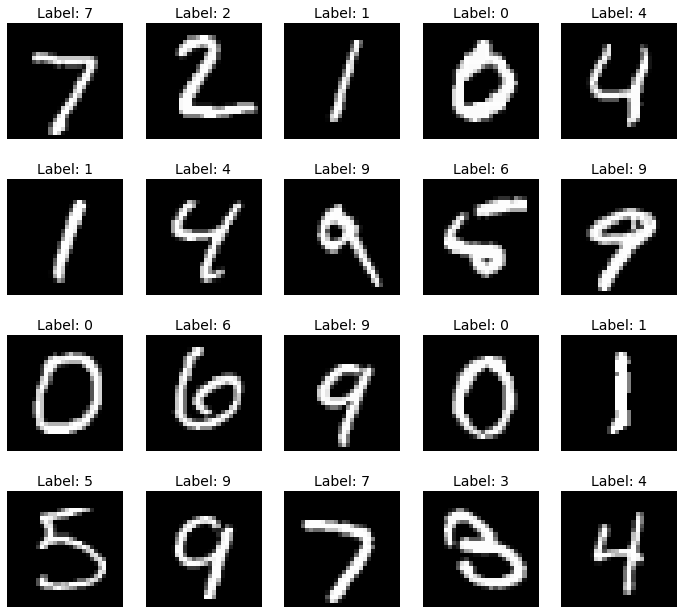

In [ ]:
# 2. Show the predictions of the first 20 images of the test dataset
images, labels = iter(test_loader).next()
images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(12, 11))

# ------------------
for i in range(20):

  plt.subplot(4, 5, i+1)
  plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
  plt.title(f'Label: {pred[i]}', fontsize=14)
  plt.axis('off')
# ------------------

# ------------------

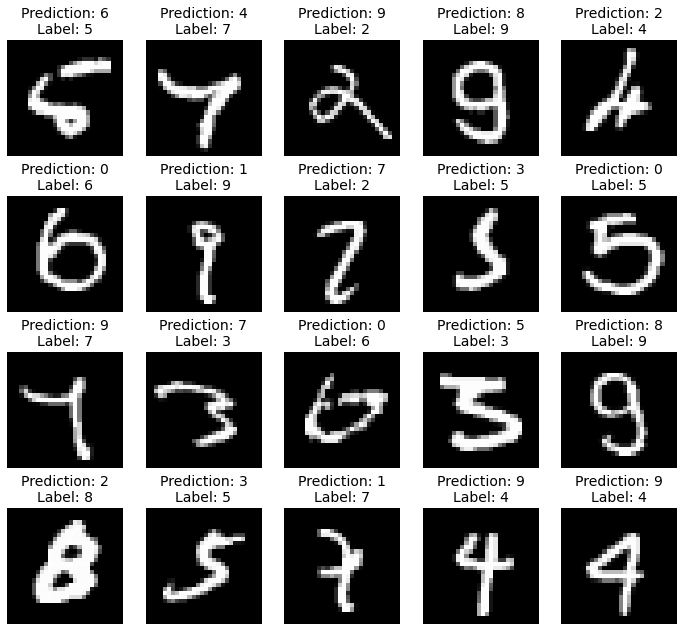

In [ ]:
# 3. Get 20 incorrect predictions in test dataset

incorrect_imgs=[]
incorrect_preds=[]
incorrect_labels=[]

with torch.no_grad():
  img, label = iter(test_loader).next()
  img, label = img.reshape(-1,28*28).to(DEVICE), label.to(DEVICE)

  # ------------------

  output = model(images)
  for i, (img, label) in enumerate(test_loader):
      output = model(img)
      # pred = None # Get index of largest log-probability and use that as prediction
      for idx, i in enumerate(output):
        pred=torch.argmax(i)
        if  pred != label[idx]:
          incorrect_imgs.append(img[idx]) #reference: https://github.com/ScarletMcLearn/DataScience/blob/master/Deep%20Learning/Image%20Classification/PyTorch%20-%20Fashion%20-%20MNIST%20-%203.ipynb
          incorrect_preds.append(pred)
          incorrect_labels.append(label[idx])

# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')


Before normalization:
Train Accuracy was ~92.8% and test accuracy was ~92.7%

### Implement a convolutional neural network to recognize hand-written digits

In [ ]:
# Setup
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 18
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [ ]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
# train_mean = train_data.data.double().mean() / 255.
# train_std = train_data.data.double().std() / 255.
# print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
#])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
import numpy
import torch.nn.functional as F

In [ ]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

# [(n+2p-k)/s]+1
class CNN(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1,out_channels = 10,kernel_size = 5,stride = 1,padding = 0), # first convolutional layer
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 10,out_channels = 20,kernel_size = 5,stride = 1,padding = 0), # second convolutional layer
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))

        self.fc = torch.nn.Linear(int(20*((((numpy.sqrt(input_size)+2*(0)-5)+1)/2)+2*(0)-5+1)/2*((((numpy.sqrt(input_size)+2*(0)-5)+1)/2)+2*(0)-5+1)/2),10) # third fully-connected layer
        self.softmax = torch.nn.LogSoftmax(dim=1)
        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        # x = self.flatten(x)
        
        # ------------------
        x = self.conv1(x)
        x = self.conv2(x)

        x = (x.reshape(-1,int(20*((((numpy.sqrt(input_size)+2*(0)-5)+1)/2)+2*(0)-5+1)/2*((((numpy.sqrt(input_size)+2*(0)-5)+1)/2)+2*(0)-5+1)/2)))
        x = (self.fc(x))
        # x = self.act(x)
        x = self.softmax(x)

        y_output = x
        
        return y_output
        # ------------------

model = CNN().to(DEVICE)

# sanity check
print(model)
from torchsummary import summary
summary(model, (1,28,28))

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=320, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              ReLU-2           [-1, 10, 24, 24]               0
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
              ReLU-5             [-1, 20, 8, 8]               0
         MaxPool2d-6             [-1

Write a method called `train_one_epoch` that runs one step using the optimizer.

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    train_num_correct = 0
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # ------------------
        output = model(img)

        _,pred_lab = torch.max(output.data,1)
        train_num_correct += (pred_lab == label.data).sum()

        loss = criterion(output,label)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # ------------------
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:    
          losses.append(loss.item())
          counter.append(
              (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter, train_num_correct

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [ ]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    test_num_correct = 0
    
    with torch.no_grad():
        for i,(img, label) in enumerate(test_loader):
            
          img, label = img.to(device), label.to(device)

          # ------------------
          pred = None # Get index of largest log-probability and use that as prediction

          output = model(img)
          _,pred_lab = torch.max(output.data,1)
          test_num_correct += (pred_lab == label.data).sum()
          test_loss += criterion(output, label)

    test_loss /= len(test_loader.dataset)
    return test_loss, test_num_correct

Train the model using the cell below. Hyperparameters are given.

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# # using Negative Loss Likelihood - softmax is applied at the output layer 
criterion = torch.nn.NLLLoss()


train_losses = []
train_counter = []
test_losses = []
test_correct = []
train_correct = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter, x= train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss,test_num_correct = test_one_epoch(test_loader, model, DEVICE)
    tr_loss,train_num_correct = test_one_epoch(train_loader,model,DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_correct.append(train_num_correct)
    train_counter.extend(counter)

    test_losses.append(test_loss)
    test_correct.append(test_num_correct)


Epochs: 100%|██████████| 10/10 [06:04<00:00, 36.46s/it]


In [ ]:
print(f"Train accuracy: {train_correct[-1]/len(train_loader.dataset)}")
print(f"Test accuracy: {(test_correct)[-1]/(len(test_loader.dataset))}")

Train accuracy: 0.9785000085830688
Test accuracy: 0.9797000288963318


In [ ]:
print("Training Cross Entropy loss:",numpy.average(train_losses))
print("Testing Cross Entropy loss:",numpy.average(test_losses))

Training Cross Entropy loss: 0.1765328852045867
Testing Cross Entropy loss: 0.0019718476


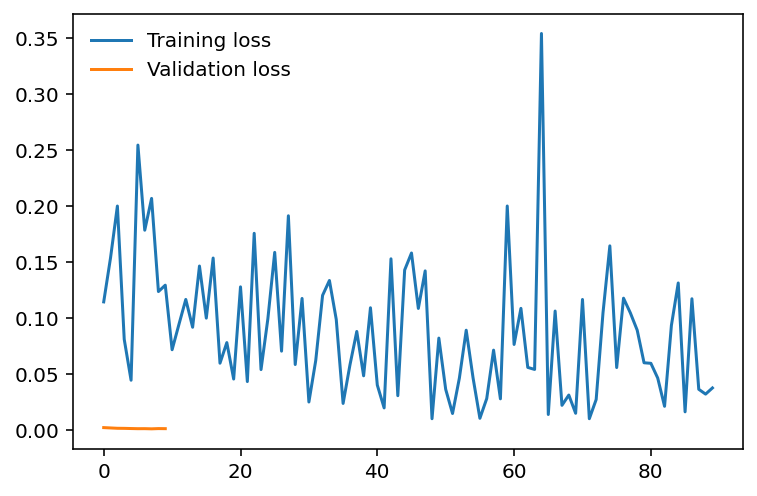

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

The test accuracy using Feedforward neural network is 96.7% and using CNN is 97.9%. Clearly CNN is giving better accuracy. 

In [ ]:
(784*128)+(128*10)+(1*128)+(1*10)

101770

In [ ]:
((5* 5* 1)+1)* 10 + ((5* 5* 10)+1)* 20 + (20* 4* 4* 10)+ (1*10)

8490

The number of parameters in the feedforward neural network are: 101,770
The number of parameters in CNN are: 8,490

Feed forward NN:(784X128)+(128X10)+(1X128)+(1X10) = 101,770

In a CNN for a conv layer: ((m * n * d)+1)* k), for a pool layer: 0, for a FC layer: (c * p)+1 * c

CNN: ((5* 5* 1)+1)* 10 + ((5* 5* 10)+1)* 20 + (20* 4* 4* 10)+ (1*10) = 8,490

Clearly, CNN is parameter efficient. 
